In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [2]:
# MSDL connectivity matrices for nilearn connectome

import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using MSDL atlas"""
    logging.info(f"Processing subject: {ss}")
    
    # Load MSDL atlas
    atlas = datasets.fetch_atlas_msdl()
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/reg_standard/filtered_func_run-0{rn}_standard.nii.gz' # corrected standard space path
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the MSDL atlas
        masker = NiftiMapsMasker(
            maps_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    # Create output directory if it doesn't exist
    output_dir = f'{results_dir}/connectivity_matrices_MSDL'
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each subject
    for ss in subs:
        try:
            connectivity_matrix = create_connectivity_matrix(ss)
            if connectivity_matrix is not None:
                output_path = f'{output_dir}/{ss}_connectivity_matrix_MSDL.npy'
                np.save(output_path, connectivity_matrix)
                logging.info(f'Saved MSDL connectivity matrix for {ss} at {output_path}')
                logging.info(f'Matrix shape: {connectivity_matrix.shape}')  # Should be (39, 39) for MSDL
        except Exception as e:
            logging.error(f"Error processing subject {ss}: {str(e)}")
            continue

if __name__ == "__main__":
    main()

2024-11-15 15:28:41,858 - INFO - Processing subject: sub-025
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/maskers/base_masker.py:253: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(
2024-11-15 15:29:42,288 - INFO - Saved MSDL connectivity matrix for sub-025 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-025_connectivity_matrix_MSDL.npy
2024-11-15 15:29:42,289 - INFO - Matrix shape: (39, 39)
2024-11-15 15:29:42,290 - INFO - Processing subject: sub-038
/home/csimmon2/anaconda3/envs/network/lib/python3.8/site-packages/nilearn/maskers/base_masker.py:253: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(
2024-11-15 15:30:42,409 - INFO - Saved MSDL connectivity matrix for sub-038 at /user_data/csimmon2/git_repos/ptoc/results/connecti

2024-11-15 15:52:35,800 - INFO - Loaded matrix for subject sub-025
2024-11-15 15:52:35,802 - INFO - Loaded matrix for subject sub-038
2024-11-15 15:52:35,803 - INFO - Loaded matrix for subject sub-057
2024-11-15 15:52:35,805 - INFO - Loaded matrix for subject sub-059
2024-11-15 15:52:35,806 - INFO - Loaded matrix for subject sub-064
2024-11-15 15:52:35,808 - INFO - Loaded matrix for subject sub-067
2024-11-15 15:52:35,809 - INFO - Loaded matrix for subject sub-068
2024-11-15 15:52:35,811 - INFO - Loaded matrix for subject sub-071
2024-11-15 15:52:35,812 - INFO - Loaded matrix for subject sub-083
2024-11-15 15:52:35,813 - INFO - Loaded matrix for subject sub-084
2024-11-15 15:52:35,814 - INFO - Loaded matrix for subject sub-085
2024-11-15 15:52:35,815 - INFO - Loaded matrix for subject sub-087
2024-11-15 15:52:35,817 - INFO - Loaded matrix for subject sub-088
2024-11-15 15:52:35,818 - INFO - Loaded matrix for subject sub-093
2024-11-15 15:52:35,820 - INFO - Loaded matrix for subject sub

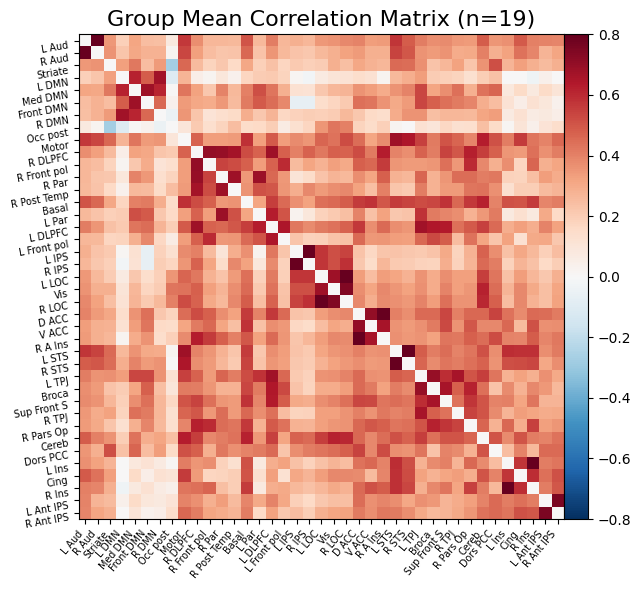

<Figure size 800x600 with 0 Axes>

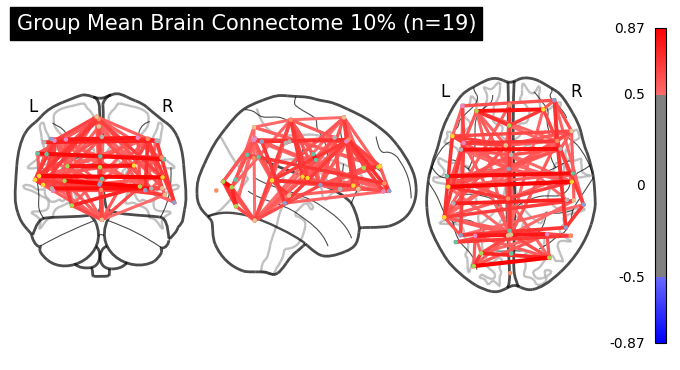

<Figure size 800x600 with 0 Axes>

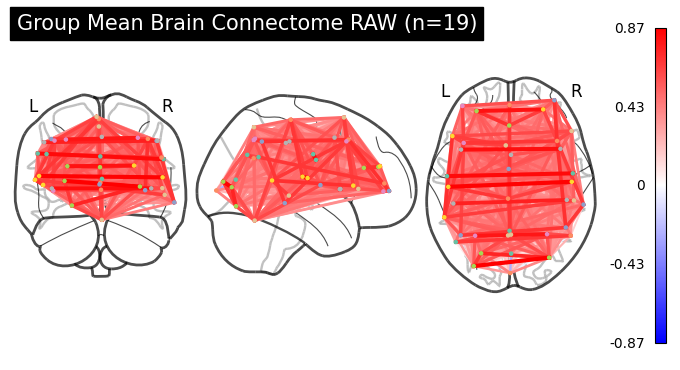


Group-Level Connectivity Statistics:
Number of subjects: 19
Shape: (39, 39)
Value range: [-0.272, 1.000]
Number of regions: 39


In [3]:
# MSDL connectivity visuals for nilearn connectome

import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def load_all_matrices():
    """Load and average matrices across all subjects"""
    all_matrices = []
    
    for sub in subs:
        matrix_path = f'{matrix_dir}/{sub}_connectivity_matrix_MSDL.npy'
        if os.path.exists(matrix_path):
            try:
                matrix = np.load(matrix_path)
                all_matrices.append(matrix)
                logging.info(f"Loaded matrix for subject {sub}")
            except Exception as e:
                logging.error(f"Error loading matrix for {sub}: {str(e)}")
    
    if not all_matrices:
        raise ValueError("No matrices were successfully loaded")
    
    # Calculate mean and standard deviation across subjects
    mean_matrix = np.mean(all_matrices, axis=0)
    std_matrix = np.std(all_matrices, axis=0)
    
    return mean_matrix, std_matrix, len(all_matrices)

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    """Create group-level visualizations"""
    # Plot 1: Correlation Matrix
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Plot 2.1: Brain Connectome as separate figure
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="85%", # threshold only for plotting
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome 10% (n={n_subjects})',
        display_mode='ortho'
    )
    # Plot 2.2: Brain Connectome as separate figure - RAW
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%", 
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome RAW (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Show both plots
    plt.show()
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%"
    )
    #view.open_in_browser()
    
    # Print connectivity statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Shape: {mean_matrix.shape}")
    print(f"Value range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Number of regions: {len(labels)}")

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

2024-11-15 15:53:07,128 - INFO - Loaded matrix for subject sub-025
2024-11-15 15:53:07,130 - INFO - Loaded matrix for subject sub-038
2024-11-15 15:53:07,132 - INFO - Loaded matrix for subject sub-057
2024-11-15 15:53:07,134 - INFO - Loaded matrix for subject sub-059
2024-11-15 15:53:07,135 - INFO - Loaded matrix for subject sub-064
2024-11-15 15:53:07,137 - INFO - Loaded matrix for subject sub-067
2024-11-15 15:53:07,139 - INFO - Loaded matrix for subject sub-068
2024-11-15 15:53:07,141 - INFO - Loaded matrix for subject sub-071
2024-11-15 15:53:07,143 - INFO - Loaded matrix for subject sub-083
2024-11-15 15:53:07,145 - INFO - Loaded matrix for subject sub-084
2024-11-15 15:53:07,147 - INFO - Loaded matrix for subject sub-085


2024-11-15 15:53:07,148 - INFO - Loaded matrix for subject sub-087
2024-11-15 15:53:07,151 - INFO - Loaded matrix for subject sub-088
2024-11-15 15:53:07,152 - INFO - Loaded matrix for subject sub-093
2024-11-15 15:53:07,155 - INFO - Loaded matrix for subject sub-094
2024-11-15 15:53:07,156 - INFO - Loaded matrix for subject sub-095
2024-11-15 15:53:07,158 - INFO - Loaded matrix for subject sub-096
2024-11-15 15:53:07,160 - INFO - Loaded matrix for subject sub-097
2024-11-15 15:53:07,162 - INFO - Loaded matrix for subject sub-107



Group-Level Connectivity Statistics:
Number of subjects: 19
Matrix shape: (39, 39)
Mean correlation range: [-0.272, 1.000]
Standard deviation range: [0.000, 0.285]

ROI-specific connections:
L LOC <-> R LOC: 0.865 ± 0.035
L LOC <-> L IPS: 0.570 ± 0.121
L LOC <-> R IPS: 0.573 ± 0.133
L LOC <-> L Ant IPS: 0.217 ± 0.159
L LOC <-> R Ant IPS: 0.286 ± 0.143
R LOC <-> L IPS: 0.541 ± 0.130
R LOC <-> R IPS: 0.582 ± 0.124
R LOC <-> L Ant IPS: 0.242 ± 0.161
R LOC <-> R Ant IPS: 0.320 ± 0.138
L IPS <-> R IPS: 0.790 ± 0.062
L IPS <-> L Ant IPS: 0.189 ± 0.194
L IPS <-> R Ant IPS: 0.246 ± 0.163
R IPS <-> L Ant IPS: 0.158 ± 0.203
R IPS <-> R Ant IPS: 0.198 ± 0.169
L Ant IPS <-> R Ant IPS: 0.753 ± 0.078


<Figure size 640x480 with 0 Axes>

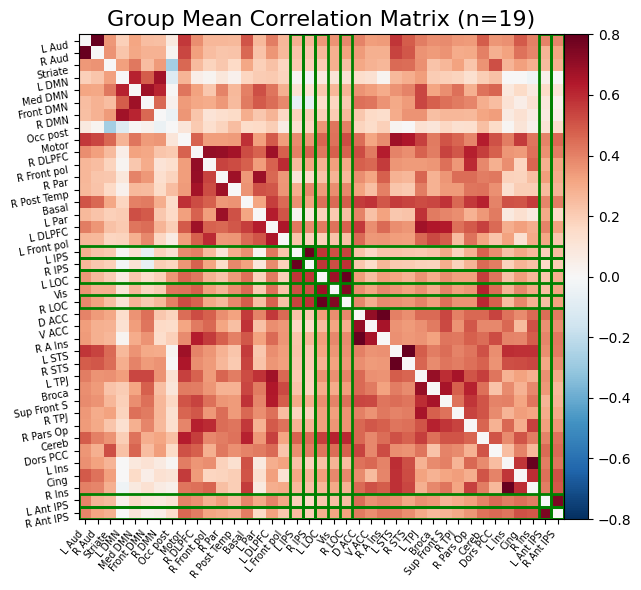

In [4]:
#highlight roi
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    
    """Create group-level visualizations with highlighted ROIs"""
    # Explicitly create a new figure
    plt.clf()  # Clear any existing figures
    fig = plt.figure(figsize=(15, 6))
    
    # Plot 1: Mean Correlation Matrix
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    # Create ROI indices with correct MSDL atlas labels
    roi_names = ['L LOC', 'R LOC', 'L IPS', 'R IPS', 'L Ant IPS', 'R Ant IPS']
    roi_indices = [labels.index(roi) for roi in roi_names]
    
    # Plot the matrix
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Add highlighting for ROIs
    n_labels = len(labels)
    for idx in roi_indices:
        # Highlight row
        ax1.add_patch(plt.Rectangle((-0.5, idx - 0.5), n_labels, 1, 
                                  fill=False, edgecolor='green', lw=2))
        # Highlight column
        ax1.add_patch(plt.Rectangle((idx - 0.5, -0.5), 1, n_labels, 
                                  fill=False, edgecolor='green', lw=2))
    
    # Save the correlation matrix plot
    #plt.savefig(f'{results_dir}/msdl_correlation_matrix_highlighted.png', 
                #dpi=300, bbox_inches='tight')
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%"
    )
    #view.open_in_browser()
    
    # Print group-level statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Matrix shape: {mean_matrix.shape}")
    print(f"Mean correlation range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Standard deviation range: [{std_matrix.min():.3f}, {std_matrix.max():.3f}]")
    
    # Add specific analysis of ROI connections
    print("\nROI-specific connections:")
    for i, roi1 in enumerate(roi_names):
        idx1 = labels.index(roi1)
        for roi2 in roi_names[i+1:]:
            idx2 = labels.index(roi2)
            correlation = mean_matrix[idx1, idx2]
            std = std_matrix[idx1, idx2]
            print(f"{roi1} <-> {roi2}: {correlation:.3f} ± {std:.3f}")\

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

Processing 19 subjects...
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  0 out of 4
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  1 out of 4
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  2 out of 4
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  3 out of 4
[GroupSparseCovarianceCV.fit] Final optimization
Analysis completed successfully
Results saved to /user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis


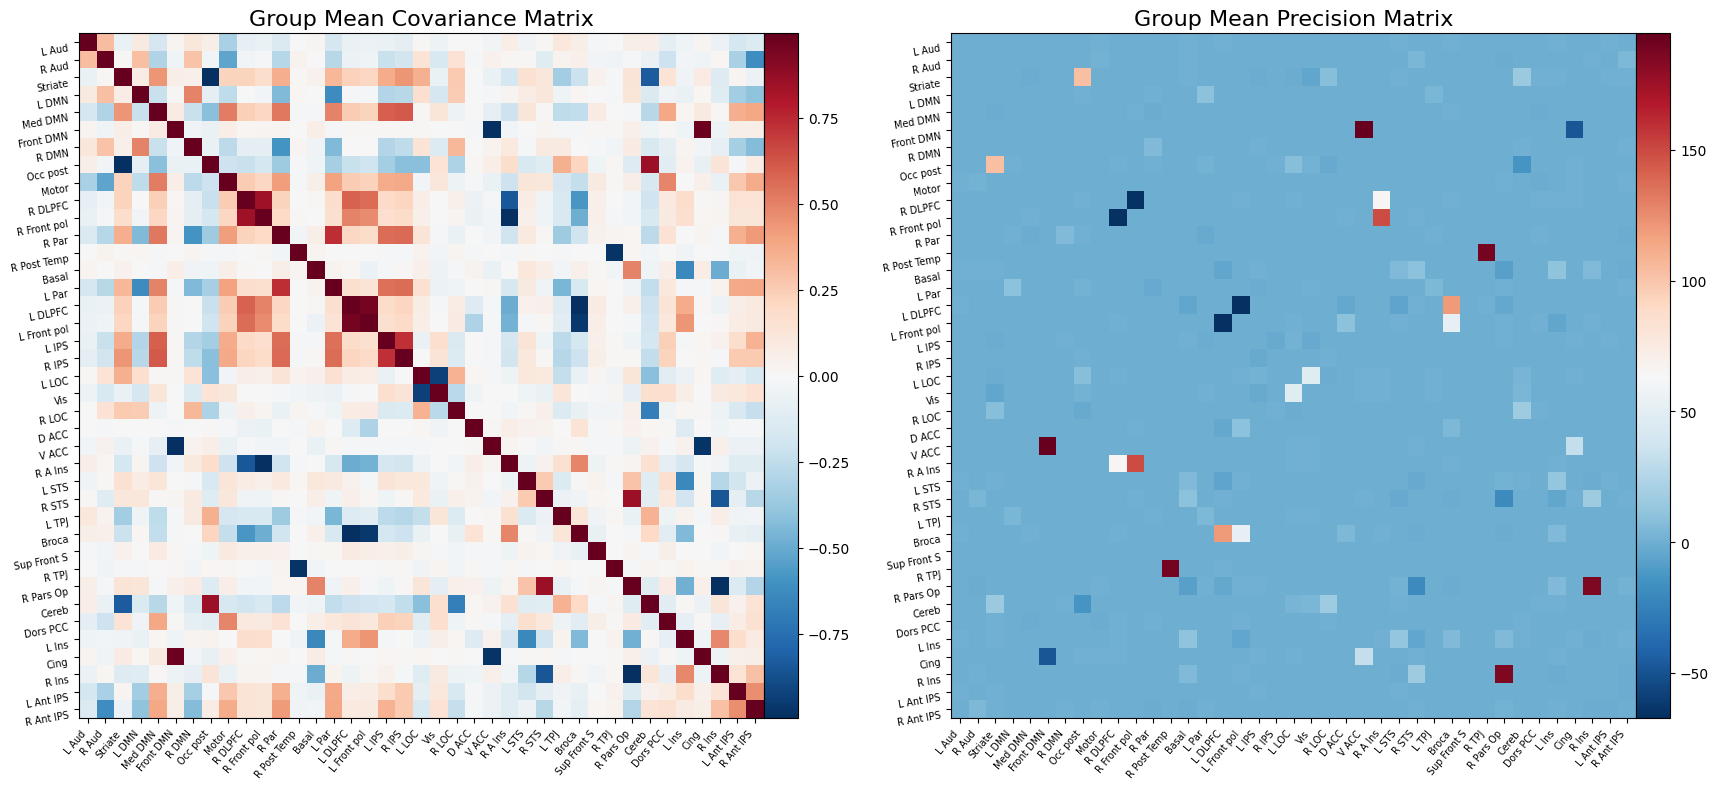

In [22]:
# groups sparse covariance [group thresholding]

import os
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import GroupSparseCovarianceCV
import matplotlib.pyplot as plt
import ptoc_params as params

def setup_directories(base_dir):
    """Setup directory structure for results"""
    results_dir = f'{base_dir}/results/connectivity_analysis'
    os.makedirs(results_dir, exist_ok=True)
    return results_dir

def extract_time_series(subject, run, atlas):
    """Extract time series data for a single run using MSDL atlas"""
    run_path = f'{params.raw_dir}/{subject}/ses-01/derivatives/fsl/loc/run-0{run}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
    
    if not os.path.exists(run_path):
        return None
        
    masker = NiftiMapsMasker(
        maps_img=atlas.maps,
        resampling_target="maps",
        detrend=True,
        high_variance_confounds=True,
        low_pass=None,
        high_pass=0.01,
        t_r=2,
        standardize="zscore_sample",
        standardize_confounds="zscore_sample",
        memory="nilearn_cache",
        memory_level=1
    )
    
    return masker.fit_transform(run_path)

def prepare_subject_data(subjects, atlas):
    """Prepare data for all subjects"""
    all_subjects_data = []
    valid_subjects = []
    
    for subject in subjects:
        all_runs = []
        for run in range(1, 4):
            time_series = extract_time_series(subject, run, atlas)
            if time_series is not None:
                if not (np.isnan(time_series).any() or np.isinf(time_series).any()):
                    all_runs.append(time_series)
        
        if all_runs:
            subject_data = np.concatenate(all_runs, axis=0)
            all_subjects_data.append(subject_data)
            valid_subjects.append(subject)
    
    return all_subjects_data, valid_subjects

def plot_group_matrices(covariances, precisions, atlas_labels, results_dir):
    """Plot group-level covariance and precision matrices"""
    # Calculate mean across subjects
    mean_covariance = np.mean(covariances, axis=2)
    mean_precision = np.mean(precisions, axis=2)
    
    plot_precision = mean_precision.copy()
    np.fill_diagonal(plot_precision, 0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plotting.plot_matrix(
        mean_covariance,
        labels=atlas_labels,
        axes=ax1,
        title='Group Mean Covariance Matrix',
        colorbar=True
    )
    
    plotting.plot_matrix(
        plot_precision,
        labels=atlas_labels,
        axes=ax2,
        title='Group Mean Precision Matrix',
        colorbar=True
    )
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/group_matrices.png')
    #plt.close()

def main():
    """Run group analysis pipeline"""
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = setup_directories(curr_dir)
    
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subjects_to_skip = []
    subs = sub_info[
        (sub_info['group'] == 'control') & 
        (~sub_info['sub'].isin(subjects_to_skip))
    ]['sub'].tolist()
    
    atlas = datasets.fetch_atlas_msdl()
    
    try:
        subjects_data, valid_subjects = prepare_subject_data(subs, atlas)
        
        if len(subjects_data) < 2:
            raise ValueError("Need at least 2 subjects for group analysis")
        
        print(f"Processing {len(subjects_data)} subjects...")
        
        # Initialize and fit the estimator
        estimator = GroupSparseCovarianceCV(verbose=True)
        estimator.fit(subjects_data)
        
        # Save the matrices (now using correct attribute names)
        np.save(f'{results_dir}/group_covariances.npy', estimator.covariances_)
        np.save(f'{results_dir}/group_precisions.npy', estimator.precisions_)
        
        # Plot matrices (passing the full 3D arrays)
        plot_group_matrices(
            estimator.covariances_,
            estimator.precisions_,
            atlas.labels,
            results_dir
        )
        
        print("Analysis completed successfully")
        print(f"Results saved to {results_dir}")
        
    except Exception as e:
        print(f"Error in execution: {str(e)}")
        print(f"Shape of subjects_data: {[x.shape for x in subjects_data]}")
        raise

if __name__ == "__main__":
    main()
    


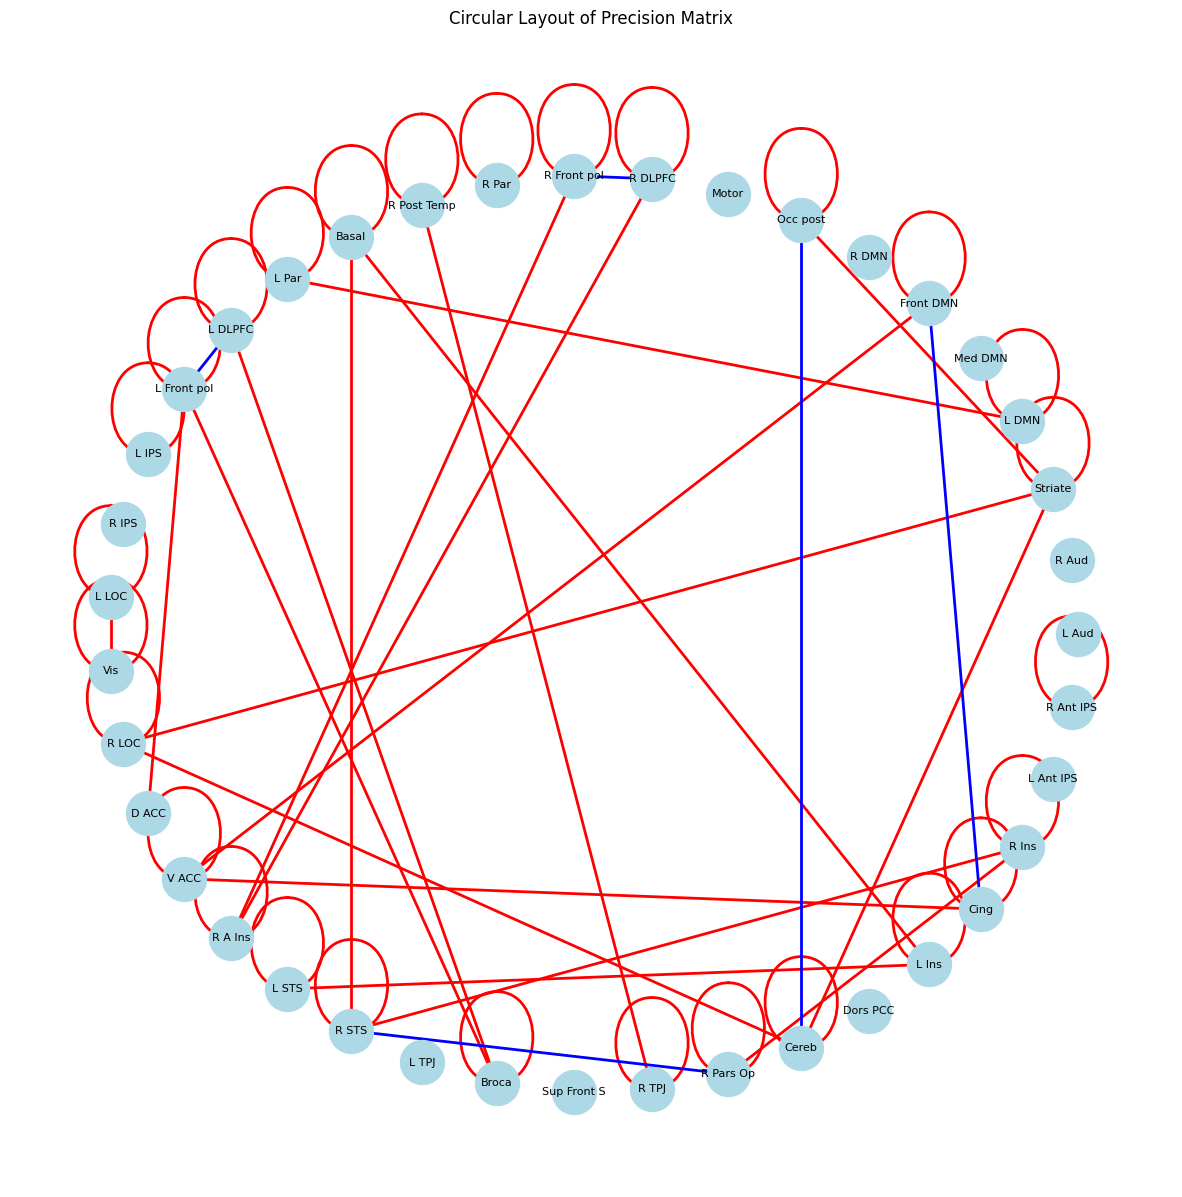

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nilearn import datasets

# Load data
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis'
precision_matrix = np.load(f'{results_dir}/group_precisions.npy').mean(axis=2)
atlas = datasets.fetch_atlas_msdl()

# Create network
threshold = np.percentile(np.abs(precision_matrix), 95)  # 95th percentile threshold
adj_matrix = np.where(np.abs(precision_matrix) > threshold, precision_matrix, 0)
G = nx.from_numpy_array(adj_matrix)

# Rename nodes
mapping = {i: label for i, label in enumerate(atlas.labels)}
G = nx.relabel_nodes(G, mapping)

# Set up plot
plt.figure(figsize=(15, 15))

# Get circular layout
pos = nx.circular_layout(G)

# Draw edges with different colors for positive/negative weights
edges = G.edges(data=True)
pos_edges = [(u, v) for (u, v, d) in edges if d['weight'] > 0]
neg_edges = [(u, v) for (u, v, d) in edges if d['weight'] < 0]

# Draw network
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color='red', width=2)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color='blue', width=2)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Circular Layout of Precision Matrix')
plt.axis('off')
plt.show()

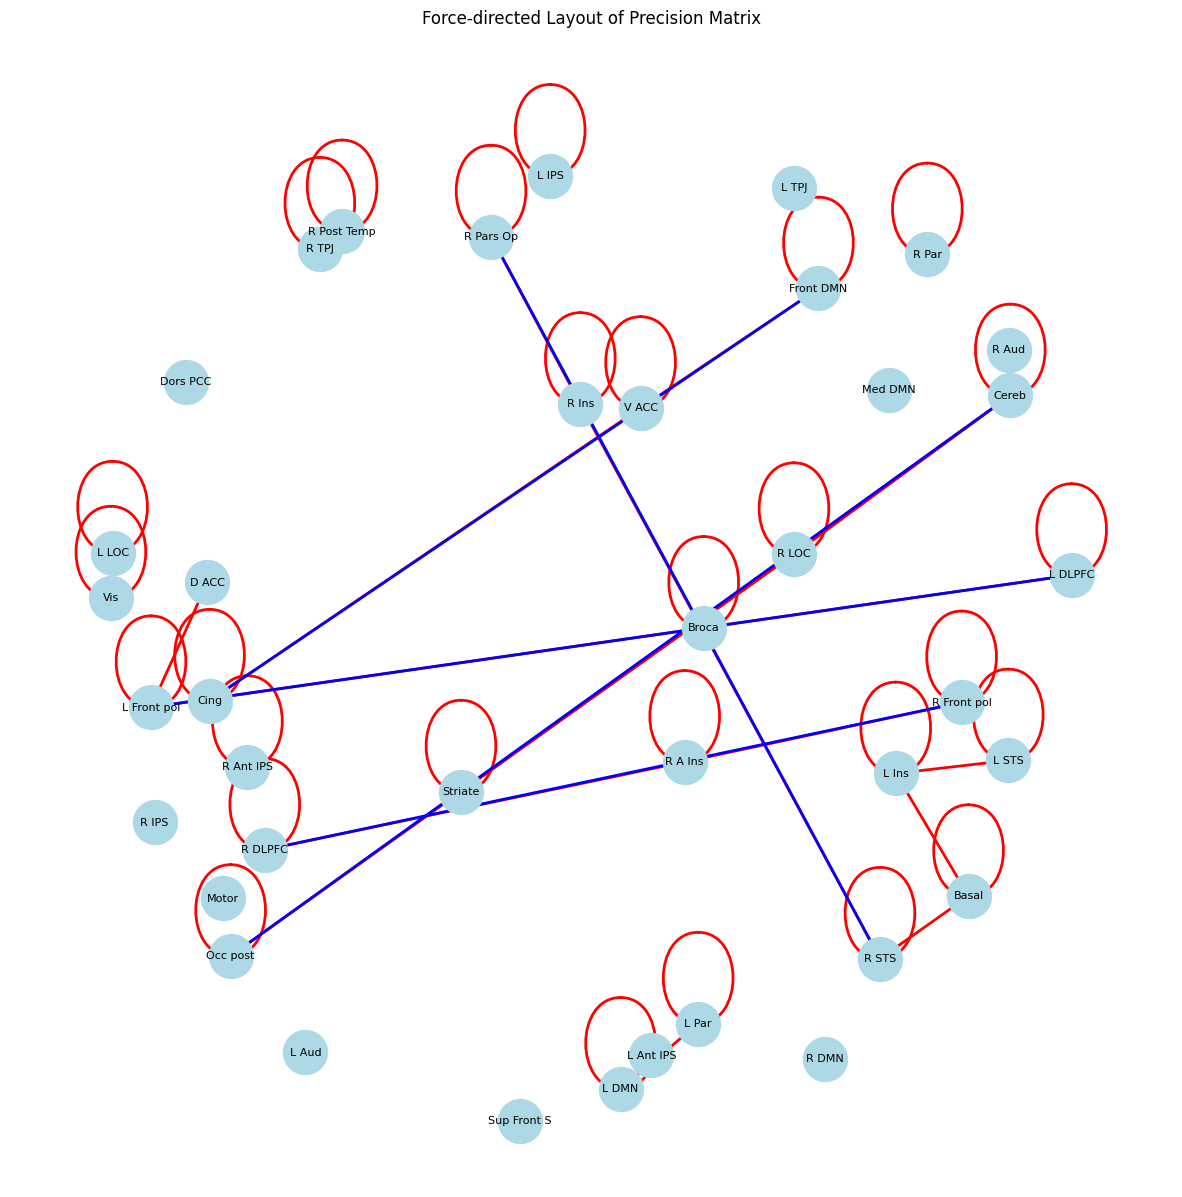

In [3]:
# Force-directed Layout
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def create_force_directed_plot(precision_matrix, labels, threshold_percentile=95):
    # Threshold the matrix
    threshold = np.percentile(np.abs(precision_matrix), threshold_percentile)
    adj_matrix = np.where(np.abs(precision_matrix) > threshold, precision_matrix, 0)
    
    # Create network
    G = nx.from_numpy_array(adj_matrix)
    
    # Rename nodes with labels
    mapping = {i: label for i, label in enumerate(labels)}
    G = nx.relabel_nodes(G, mapping)
    
    # Set up plot
    plt.figure(figsize=(15, 15))
    
    # Get position layout
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw edges with different colors for positive/negative weights
    edges = G.edges(data=True)
    pos_edges = [(u, v) for (u, v, d) in edges if d['weight'] > 0]
    neg_edges = [(u, v) for (u, v, d) in edges if d['weight'] < 0]
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color='red', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color='blue', width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title('Force-directed Layout of Precision Matrix')
    plt.axis('off')
    plt.show()

# Load and plot
precision_matrix = np.load(f'{results_dir}/group_precisions.npy').mean(axis=2)
create_force_directed_plot(precision_matrix, atlas.labels)

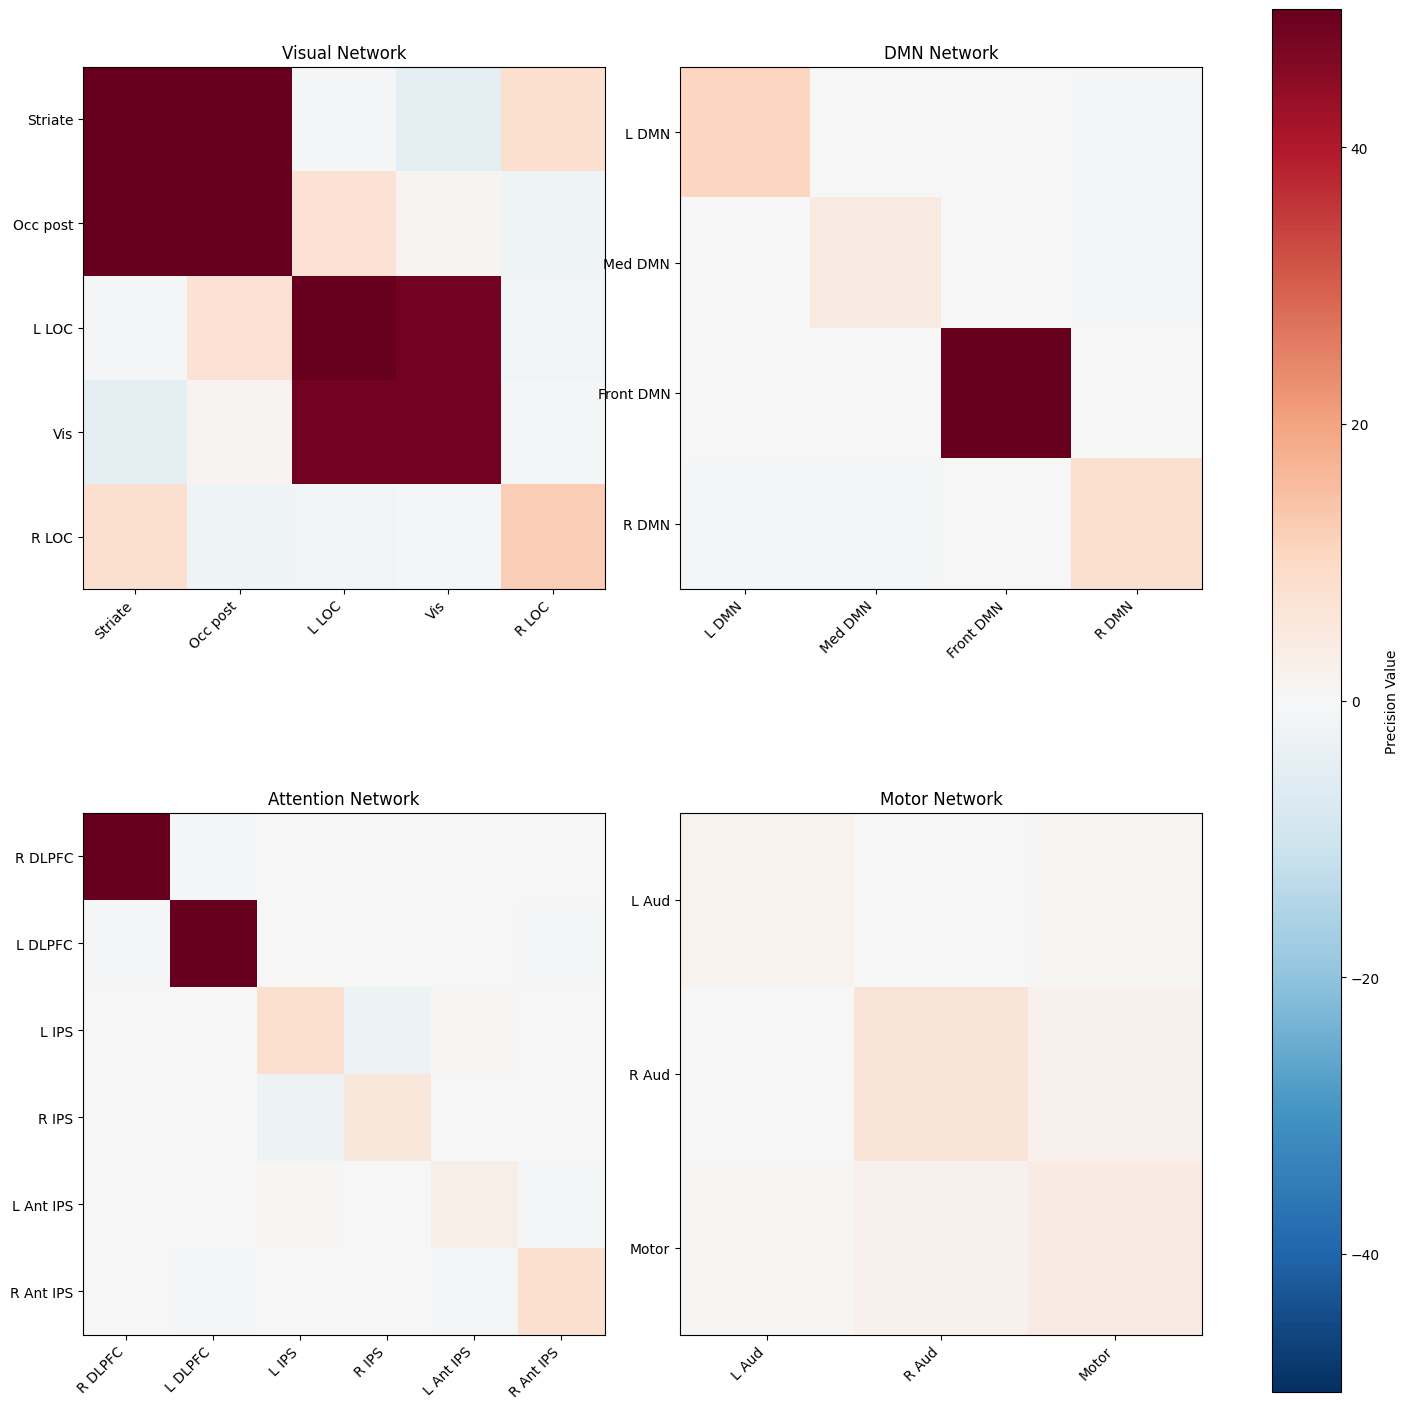


Strongest Connections within Networks:

Visual Network:
Striate -- Occ post: 102.728

DMN Network:
L DMN -- R DMN: -0.502

Attention Network:
L Ant IPS -- R Ant IPS: -0.954
L IPS -- R IPS: -2.671

Motor Network:
R Aud -- Motor: 2.206


In [4]:
# Subnetwork Analysis
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# Load data
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis'
precision_matrix = np.load(f'{results_dir}/group_precisions.npy').mean(axis=2)
atlas = datasets.fetch_atlas_msdl()

# Define networks
networks = {
   'Visual': ['Striate', 'Occ post', 'L LOC', 'R LOC', 'Vis'],
   'DMN': ['Med DMN', 'Front DMN', 'L DMN', 'R DMN'],
   'Attention': ['L IPS', 'R IPS', 'L Ant IPS', 'R Ant IPS', 'L DLPFC', 'R DLPFC'],
   'Motor': ['Motor', 'L Aud', 'R Aud']
}

def extract_network_matrix(full_matrix, network_regions, all_labels):
   # Get indices for network regions
   indices = [i for i, label in enumerate(all_labels) if label in network_regions]
   return full_matrix[np.ix_(indices, indices)], [all_labels[i] for i in indices]

# Plot subnetworks
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, (network_name, regions) in enumerate(networks.items()):
   submatrix, labels = extract_network_matrix(precision_matrix, regions, atlas.labels)
   
   im = axes[idx].imshow(submatrix, cmap='RdBu_r', vmin=-50, vmax=50)
   axes[idx].set_xticks(range(len(labels)))
   axes[idx].set_yticks(range(len(labels)))
   axes[idx].set_xticklabels(labels, rotation=45, ha='right')
   axes[idx].set_yticklabels(labels)
   axes[idx].set_title(f'{network_name} Network')

plt.tight_layout()
plt.colorbar(im, ax=axes, label='Precision Value')
plt.show()

# Print strongest connections within each network
print("\nStrongest Connections within Networks:")
for network_name, regions in networks.items():
   submatrix, labels = extract_network_matrix(precision_matrix, regions, atlas.labels)
   np.fill_diagonal(submatrix, 0)  # Remove diagonal
   
   # Get top 3 strongest connections
   flat_indices = np.argsort(np.abs(submatrix).ravel())[-3:]
   row_indices, col_indices = np.unravel_index(flat_indices, submatrix.shape)
   
   print(f"\n{network_name} Network:")
   for r, c in zip(row_indices, col_indices):
       if r < c:  # Avoid duplicates
           print(f"{labels[r]} -- {labels[c]}: {submatrix[r,c]:.3f}")

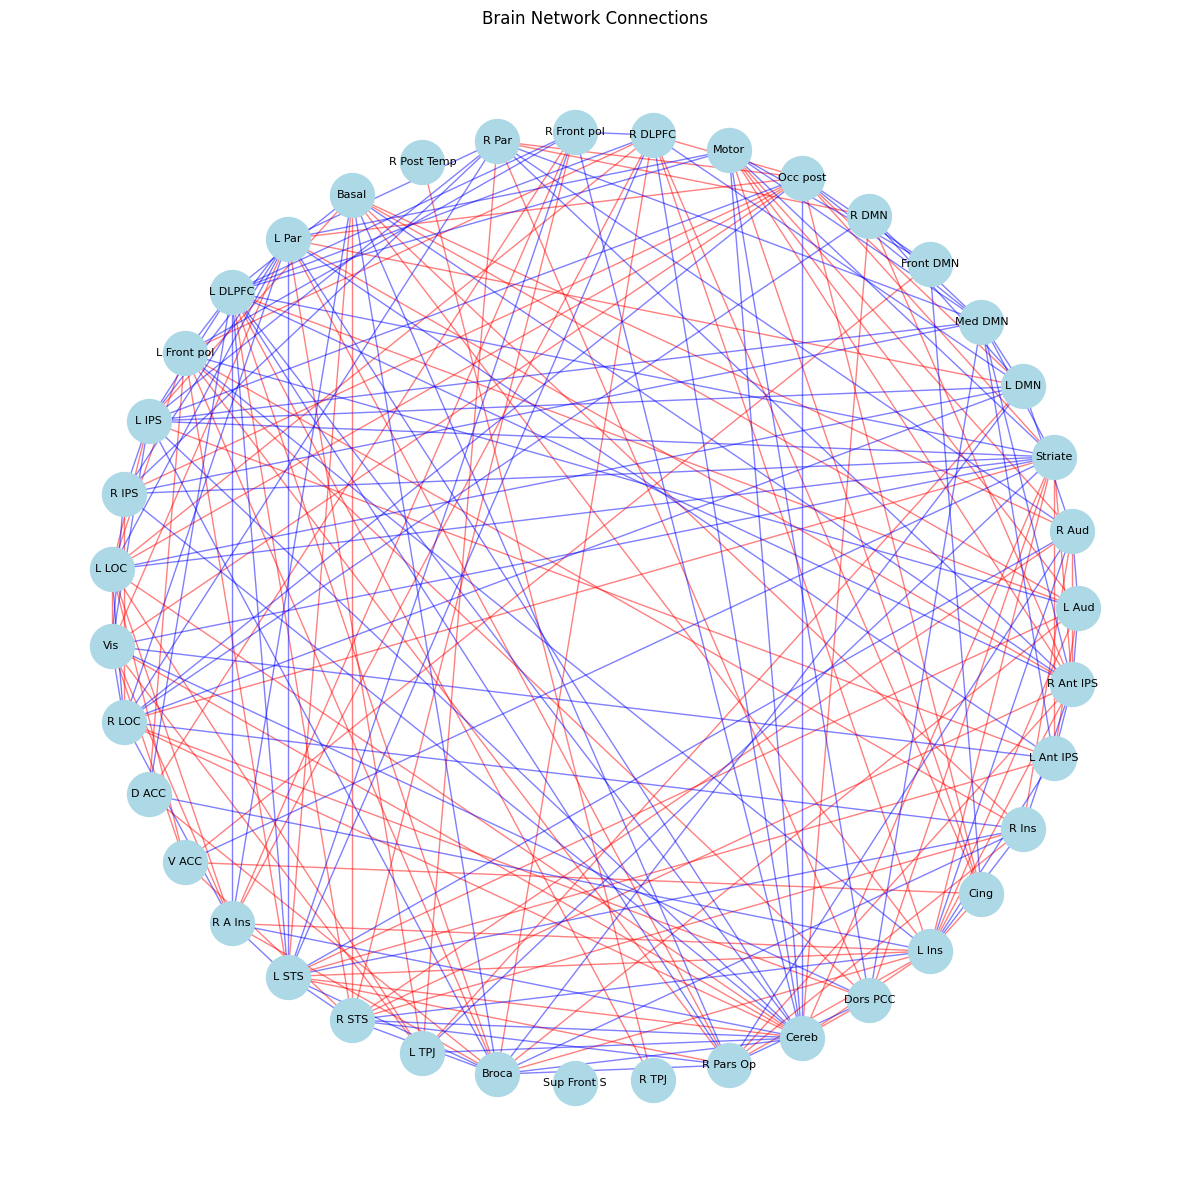

In [17]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets

# Load data
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis'
precision_matrix = np.load(f'{results_dir}/group_precisions.npy').mean(axis=2)
atlas = datasets.fetch_atlas_msdl()

# Create network
G = nx.Graph()
for i, label in enumerate(atlas.labels):
    G.add_node(label)

# Add edges above threshold
threshold = np.percentile(np.abs(precision_matrix), 70)
for i, label1 in enumerate(atlas.labels):
    for j, label2 in enumerate(atlas.labels):
        if i < j and abs(precision_matrix[i,j]) > threshold:
            G.add_edge(label1, label2, weight=precision_matrix[i,j])

# Create plot
plt.figure(figsize=(12,12))
pos = nx.circular_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=8)

# Draw edges with colors based on sign
pos_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0]
neg_edges = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0]

nx.draw_networkx_edges(G, pos, edgelist=pos_edges, edge_color='red', alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=neg_edges, edge_color='blue', alpha=0.5)

plt.axis('off')
plt.title('Brain Network Connections')
plt.tight_layout()
plt.show()

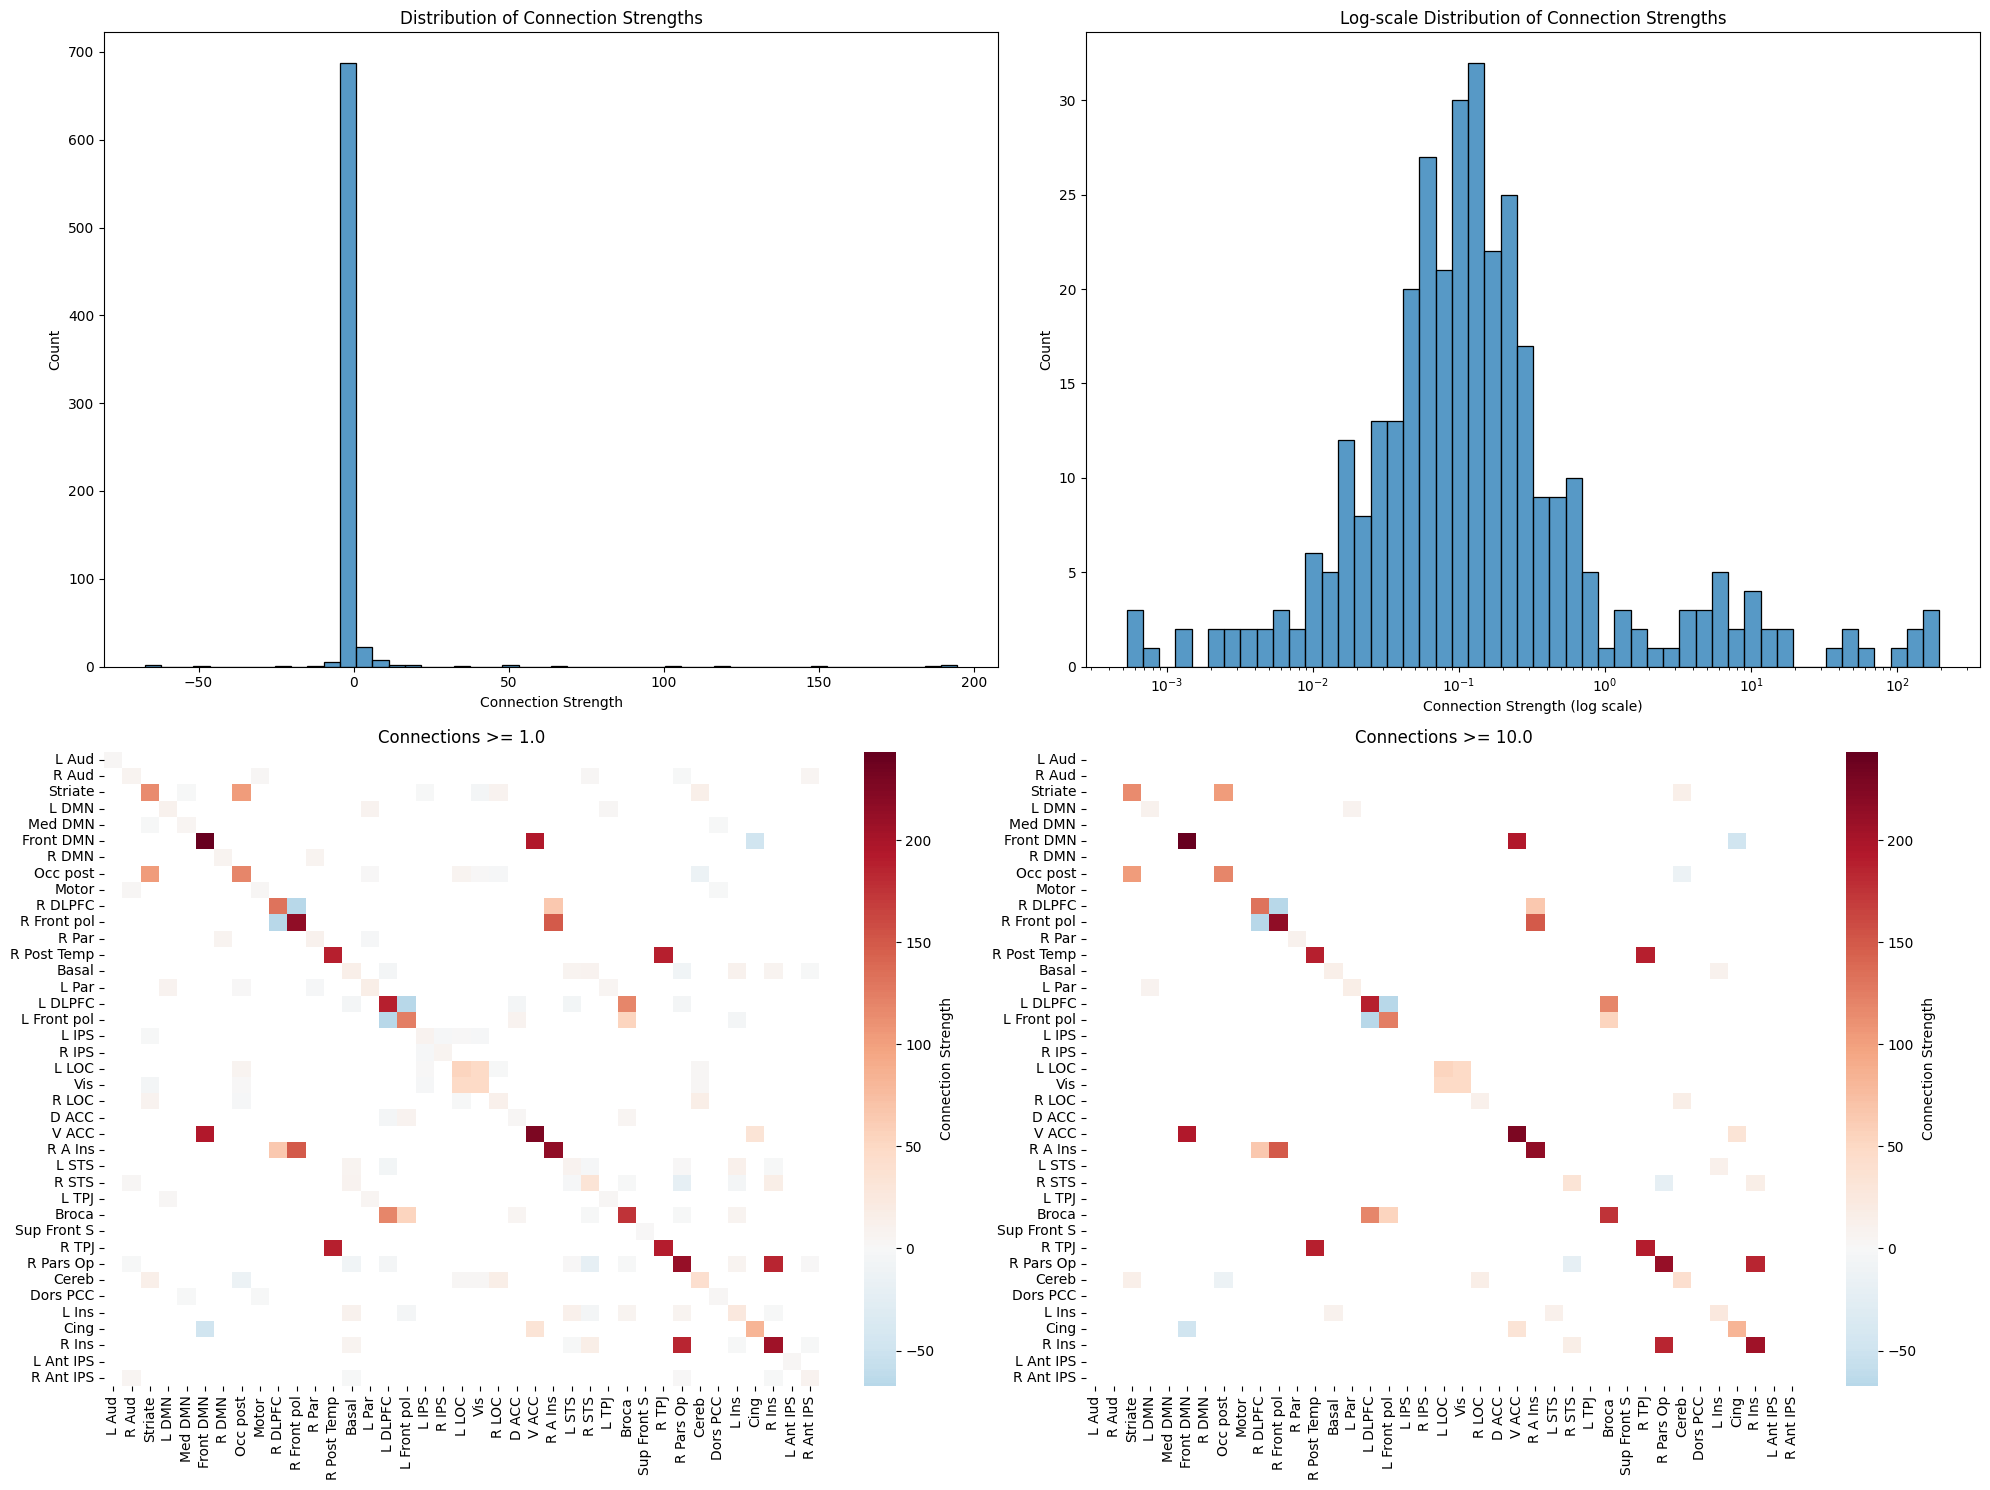

Analysis completed and saved


In [16]:
import os
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns

def plot_connectivity_analysis(precisions, atlas_labels, threshold_levels=[1.0, 10.0]):
    """Plot connectivity analysis from precision matrices"""
    fig = plt.figure(figsize=(20, 15))
    
    # Convert precision matrix to connection list
    n_regions = len(atlas_labels)
    connections = []
    mean_precision = np.mean(precisions, axis=2)
    
    for i in range(n_regions):
        for j in range(i+1, n_regions):
            if mean_precision[i,j] != 0:
                connections.append([atlas_labels[i], atlas_labels[j], mean_precision[i,j]])
    
    connections_df = pd.DataFrame(connections, columns=['from', 'to', 'strength'])
    
    # Distribution plot
    plt.subplot(2, 2, 1)
    sns.histplot(data=connections_df, x='strength', bins=50)
    plt.title('Distribution of Connection Strengths')
    plt.xlabel('Connection Strength')
    plt.ylabel('Count')
    
    # Log-scale distribution
    plt.subplot(2, 2, 2)
    sns.histplot(data=connections_df, x='strength', bins=50, log_scale=True)
    plt.title('Log-scale Distribution of Connection Strengths')
    plt.xlabel('Connection Strength (log scale)')
    plt.ylabel('Count')
    
    # Two threshold matrices
    for idx, thresh in enumerate(threshold_levels):
        plt.subplot(2, 2, idx + 3)
        
        mask_matrix = np.ones_like(mean_precision)
        masked_precision = mean_precision.copy()
        
        mask_matrix[np.abs(mean_precision) >= thresh] = 0
        masked_precision[np.abs(mean_precision) < thresh] = 0
        
        sns.heatmap(masked_precision, mask=mask_matrix,
                   cmap='RdBu_r', center=0,
                   xticklabels=atlas_labels, yticklabels=atlas_labels,
                   cbar_kws={'label': 'Connection Strength'})
        plt.title(f'Connections >= {thresh}')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
    
    plt.tight_layout()
    return fig

def main():
    """Run visualization pipeline"""
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = f'{curr_dir}/results/connectivity_analysis'
    
    # Load precision matrices and atlas
    precisions = np.load(f'{results_dir}/group_precisions.npy')
    atlas = datasets.fetch_atlas_msdl()
    
    # Create and save plots
    fig = plot_connectivity_analysis(precisions, atlas.labels)
    plt.savefig(f'{results_dir}/connectivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Analysis completed and saved")

if __name__ == "__main__":
    main()

In [ ]:
# print precision matrix connections

import numpy as np
from nilearn import datasets

def analyze_raw_connections(precision_matrix, atlas_labels):
    """
    Analyze all non-zero connections from the precision matrix 
    (already thresholded by GroupSparseCovarianceCV)
    """
    n_regions = len(atlas_labels)
    connections = []
    
    # Get all non-zero connections from upper triangle
    for i in range(n_regions):
        for j in range(i+1, n_regions):
            value = precision_matrix[i, j]
            if value != 0:  # Only look at non-zero connections
                connections.append({
                    'region1': atlas_labels[i],
                    'region2': atlas_labels[j],
                    'strength': value
                })
    
    # Sort by absolute strength
    connections.sort(key=lambda x: abs(x['strength']), reverse=True)
    return connections

# Load data
precision_matrix = np.load('results/connectivity_analysis/group_precisions.npy').mean(axis=2)
atlas = datasets.fetch_atlas_msdl()
atlas_labels = atlas.labels

# Get all non-zero connections
connections = analyze_raw_connections(precision_matrix, atlas_labels)

print("All Non-Zero Connections (sorted by absolute strength):")
print("-" * 70)
for conn in connections:
    print(f"{conn['region1']:<15} -- {conn['region2']:<15}: {conn['strength']:>8.2f}")

# Specifically examine LOC and IPS connections
print("\nLOC and IPS Connections:")
print("-" * 70)
for conn in connections:
    if ('LOC' in conn['region1'] or 'LOC' in conn['region2']) and \
       ('IPS' in conn['region1'] or 'IPS' in conn['region2']):
        print(f"{conn['region1']:<15} -- {conn['region2']:<15}: {conn['strength']:>8.2f}")

All Non-Zero Connections (sorted by absolute strength):
----------------------------------------------------------------------
Front DMN       -- V ACC          :   194.63
R Post Temp     -- R TPJ          :   189.47
R Pars Op       -- R Ins          :   185.64
R Front pol     -- R A Ins        :   149.18
L DLPFC         -- Broca          :   119.39
Striate         -- Occ post       :   102.73
L DLPFC         -- L Front pol    :   -67.34
R DLPFC         -- R Front pol    :   -66.19
R DLPFC         -- R A Ins        :    65.39
L Front pol     -- Broca          :    52.82
Front DMN       -- Cing           :   -48.79
L LOC           -- Vis            :    48.19
V ACC           -- Cing           :    32.93
R STS           -- R Pars Op      :   -20.22
R LOC           -- Cereb          :    17.55
R STS           -- R Ins          :    16.93
Striate         -- Cereb          :    14.98
Occ post        -- Cereb          :   -13.98
L STS           -- L Ins          :    13.05
Basal           --

Successfully averaged 19 subjects

Group Connectivity Statistics:
Mean absolute connectivity: 0.060
Max positive connectivity: 0.851
Max negative connectivity: -0.242
Standard deviation: 0.120

Analysis complete! Results saved in 'group_connectivity_analysis' directory


<Figure size 1200x1000 with 0 Axes>

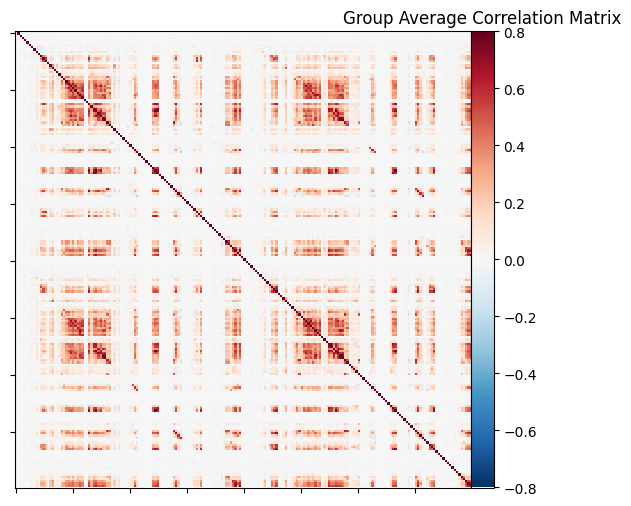

<Figure size 1500x800 with 0 Axes>

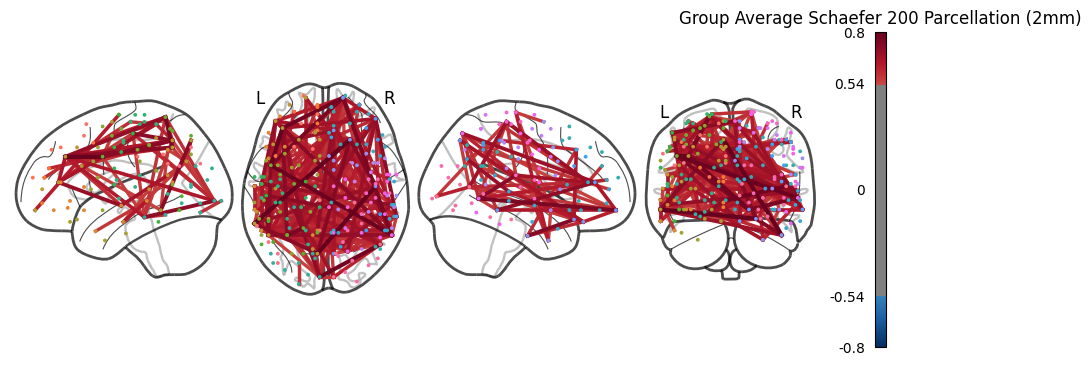

<Figure size 1500x800 with 0 Axes>

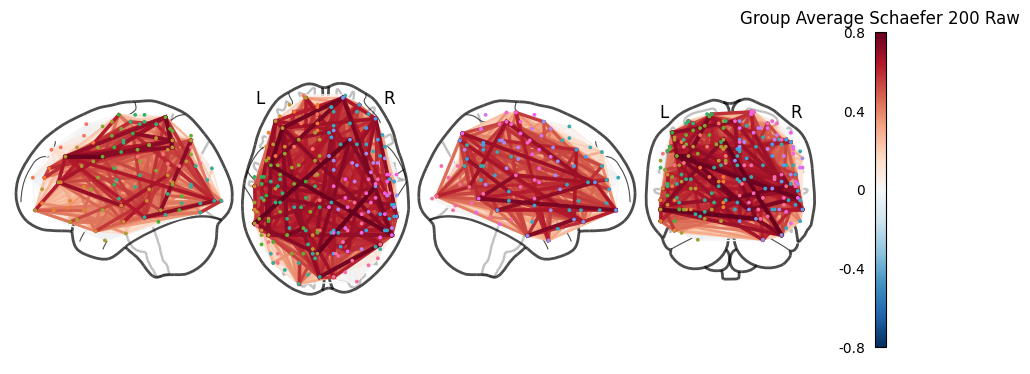

In [ ]:
# remapping schaefer 200 atlas to work with nilearn glass brain # group level 

import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

def load_and_average_matrices(subs, base_path):
    """Load and average correlation matrices for all subjects."""
    
    # Initialize with first subject to get dimensions
    first_matrix = np.load(f'{base_path}/{subs[0]}_connectivity_matrix_standard.npy')
    avg_matrix = np.zeros_like(first_matrix)
    
    valid_subjects = []
    for sub in subs:
        try:
            matrix_path = f'{base_path}/{sub}_connectivity_matrix_standard.npy'
            curr_matrix = np.load(matrix_path)
            avg_matrix += curr_matrix
            valid_subjects.append(sub)
        except Exception as e:
            print(f"Error loading subject {sub}: {str(e)}")
    
    avg_matrix /= len(valid_subjects)
    print(f"Successfully averaged {len(valid_subjects)} subjects")
    return avg_matrix

def analyze_group_connectivity(correlation_matrix, coords_df, output_dir):
    """Analyze group-level connectivity and save results."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Get coordinates
    coords = coords_df[['R', 'A', 'S']].values
    
    # Generate random colors
    node_colors = sns.color_palette('husl', n_colors=200)
    
    # Figure 1: Group Average Matrix
    plt.figure(figsize=(12, 10))
    matrix_plot = plotting.plot_matrix(
        correlation_matrix,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        cmap='RdBu_r'
    )
    plt.title('Group Average Correlation Matrix')
    #plt.savefig(output_dir / 'group_correlation_matrix.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Figure 2: Thresholded Group Brain Connectome
    plt.figure(figsize=(15, 8))
    plotting.plot_connectome(
        correlation_matrix,
        coords,
        edge_threshold='99%',
        node_size=3,
        node_color=node_colors,
        display_mode='lzry',
        edge_vmin=-0.8,
        edge_vmax=0.8,
        colorbar=True,
        edge_cmap='RdBu_r'
    )
    plt.title('Group Average Schaefer 200 Parcellation (2mm)')
    #plt.savefig(output_dir / 'group_connectome_thresholded.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Figure 3: Raw Group Brain Connectome
    plt.figure(figsize=(15, 8))
    plotting.plot_connectome(
        correlation_matrix,
        coords,
        edge_threshold='0%',
        node_size=3,
        node_color=node_colors,
        display_mode='lzry',
        edge_vmin=-0.8,
        edge_vmax=0.8,
        colorbar=True,
        edge_cmap='RdBu_r'
    )
    plt.title('Group Average Schaefer 200 Raw')
    #plt.savefig(output_dir / 'group_connectome_raw.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Calculate and save statistics
    matrix_no_diag = correlation_matrix.copy()
    np.fill_diagonal(matrix_no_diag, 0)
    
    stats = {
        'mean_abs_connectivity': np.mean(np.abs(matrix_no_diag)),
        'max_positive_connectivity': np.max(matrix_no_diag),
        'max_negative_connectivity': np.min(matrix_no_diag),
        'std_connectivity': np.std(matrix_no_diag)
    }
    
    # Get strongest connections
    top_positive = np.unravel_index(np.argsort(matrix_no_diag.ravel())[-10:], matrix_no_diag.shape)
    strong_connections = []
    for i, j in zip(top_positive[0], top_positive[1]):
        if i != j:
            connection = {
                'roi1': coords_df['ROI Name'][i],
                'roi2': coords_df['ROI Name'][j],
                'correlation': matrix_no_diag[i,j]
            }
            strong_connections.append(connection)
    
    # Save statistics and strong connections
    stats_df = pd.DataFrame([stats])
    
    connections_df = pd.DataFrame(strong_connections)
    connections_df.sort_values('correlation', ascending=False, inplace=True)
    
    # Print summary
    print("\nGroup Connectivity Statistics:")
    print(f"Mean absolute connectivity: {stats['mean_abs_connectivity']:.3f}")
    print(f"Max positive connectivity: {stats['max_positive_connectivity']:.3f}")
    print(f"Max negative connectivity: {stats['max_negative_connectivity']:.3f}")
    print(f"Standard deviation: {stats['std_connectivity']:.3f}")
    

def main():
    # Set up paths
    curr_dir = os.getcwd()
    matrix_base_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard'
    
    # Load subject information
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subjects_to_skip = []
    subs = sub_info[(sub_info['group'] == 'control') & 
                    (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()
    
    # Load coordinates
    coords_df = pd.read_csv('analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv')
    
    # Load and average correlation matrices
    avg_matrix = load_and_average_matrices(subs, matrix_base_path)
    
    # Analyze group connectivity
    output_dir = 'group_connectivity_analysis'
    analyze_group_connectivity(avg_matrix, coords_df, output_dir)
    
    print("\nAnalysis complete! Results saved in 'group_connectivity_analysis' directory")

if __name__ == "__main__":
    main()


Group Connectivity Statistics:
Mean absolute connectivity: 0.000
Max positive connectivity: 0.000
Max negative connectivity: -0.000
Standard deviation: 0.000

Top 10 strongest connections:
ROI 192 - ROI 5: 0.000
7networks_RH_Vis_ExStr_2 - 7networks_LH_Default_PCC_1
---
ROI 5 - ROI 192: 0.000
7networks_LH_Default_PCC_1 - 7networks_RH_Vis_ExStr_2
---
ROI 171 - ROI 168: 0.000
7networks_RH_SomMot_10 - 7networks_RH_DorsAttn_TempOcc_2
---
ROI 168 - ROI 171: 0.000
7networks_RH_DorsAttn_TempOcc_2 - 7networks_RH_SomMot_10
---
ROI 159 - ROI 168: 0.000
7networks_RH_DorsAttn_PostC_2 - 7networks_RH_DorsAttn_TempOcc_2
---
ROI 168 - ROI 159: 0.000
7networks_RH_DorsAttn_TempOcc_2 - 7networks_RH_DorsAttn_PostC_2
---
ROI 195 - ROI 8: 0.000
7networks_RH_Vis_ExStr_5 - 7networks_LH_Default_PFCd_2
---
ROI 8 - ROI 195: 0.000
7networks_LH_Default_PFCd_2 - 7networks_RH_Vis_ExStr_5
---
ROI 59 - ROI 56: 0.000
7networks_LH_DorsAttn_PostC_2 - 7networks_LH_DorsAttn_IPS_1
---
ROI 56 - ROI 59: 0.000
7networks_LH_Dor

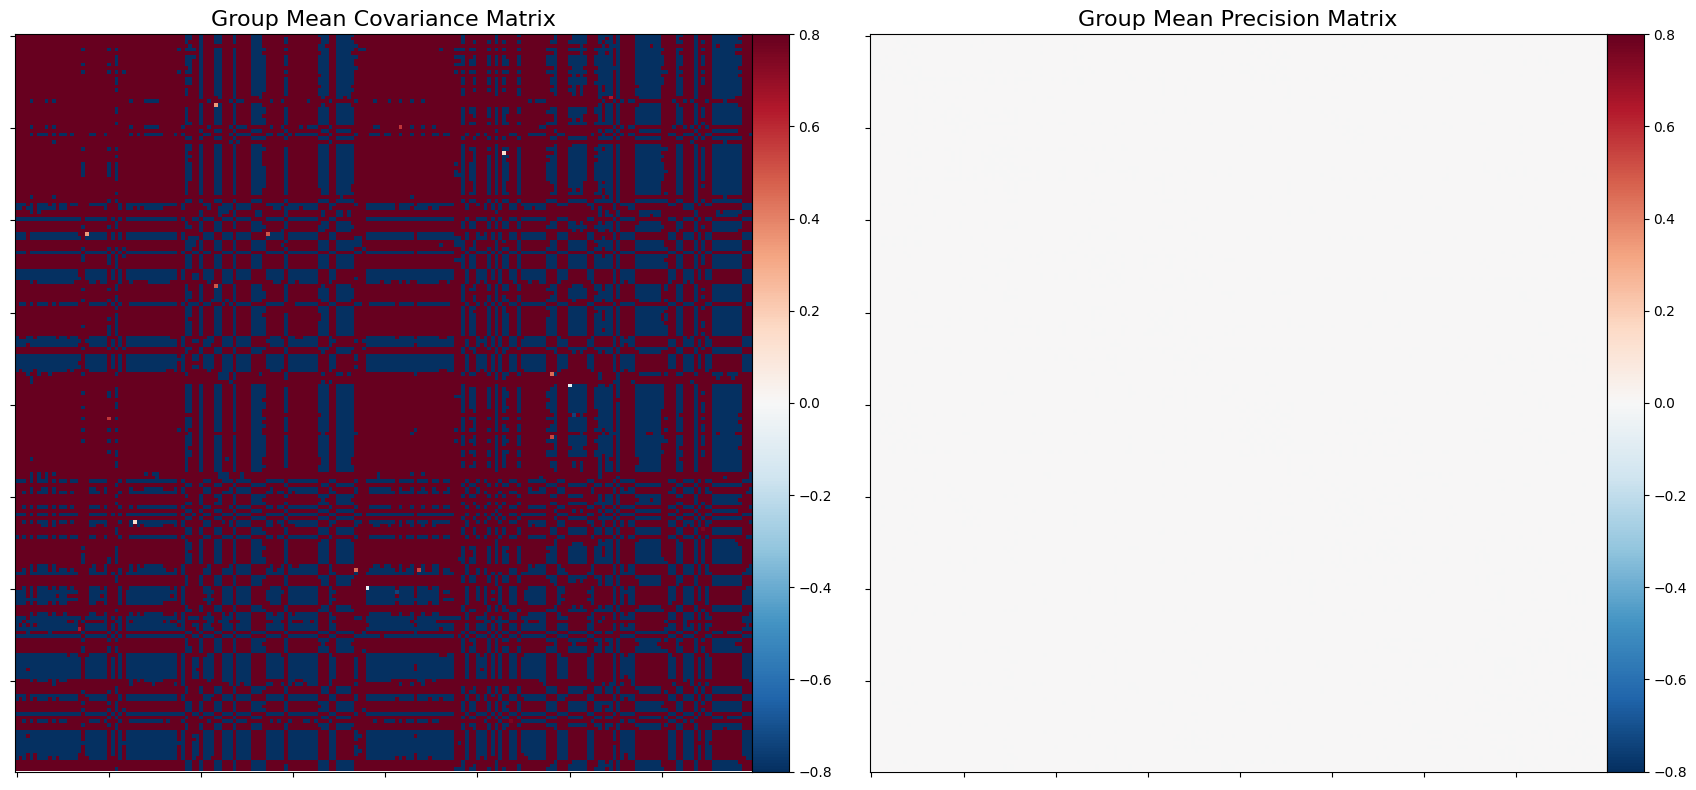

<Figure size 1500x800 with 0 Axes>

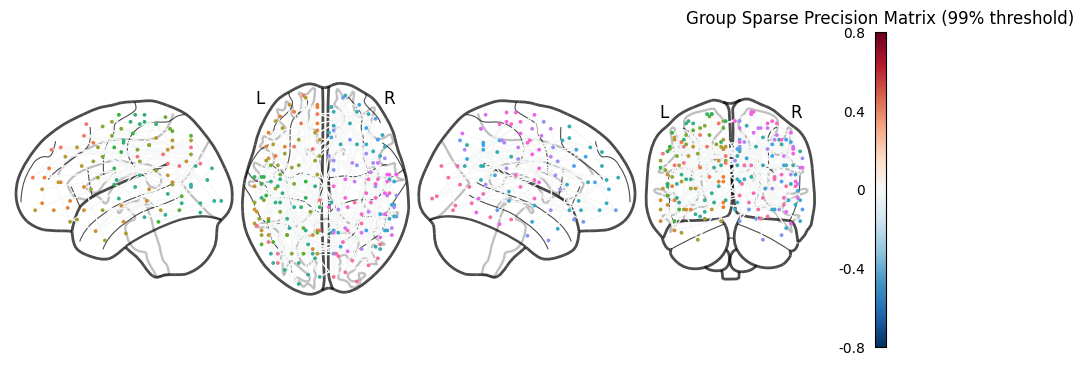

<Figure size 1500x800 with 0 Axes>

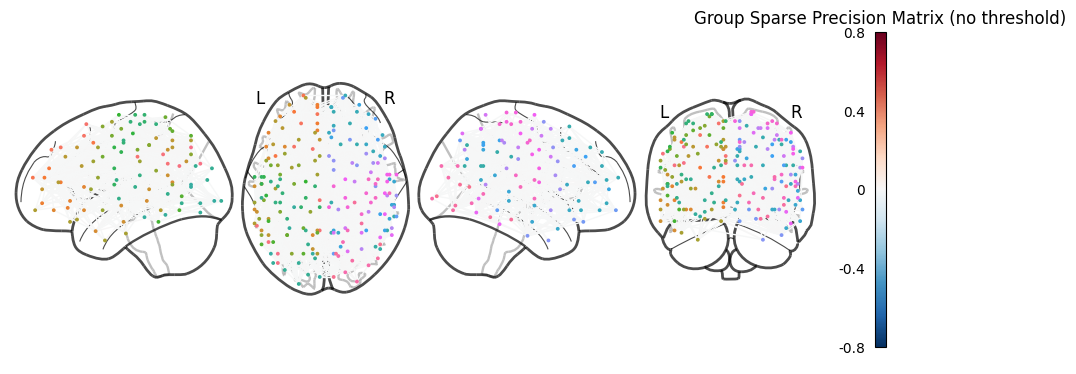

In [1]:
import os
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def plot_group_matrices(covariances, precisions, coords_df, results_dir):
    """Create comprehensive visualization of connectivity results"""
    results_dir = Path(results_dir)
    results_dir.mkdir(parents=True, exist_ok=True)
    
    # Calculate mean matrices
    mean_covariance = np.mean(covariances, axis=2)
    mean_precision = np.mean(precisions, axis=2)
    
    # Get coordinates for connectome visualization
    coords = coords_df[['R', 'A', 'S']].values
    
    # Generate colors for nodes
    node_colors = sns.color_palette('husl', n_colors=200)
    
    # Figure 1: Group Average Matrices (Covariance and Precision)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plotting.plot_matrix(
        mean_covariance,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        axes=ax1,
        cmap='RdBu_r',
        title='Group Mean Covariance Matrix'
    )
    
    # For precision matrix, zero out diagonal for better visualization
    plot_precision = mean_precision.copy()
    np.fill_diagonal(plot_precision, 0)
    
    plotting.plot_matrix(
        plot_precision,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        axes=ax2,
        cmap='RdBu_r',
        title='Group Mean Precision Matrix'
    )
    
    plt.tight_layout()
    #plt.savefig(results_dir / 'group_matrices.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Figure 2: Thresholded Brain Connectome (Precision)
    plt.figure(figsize=(15, 8))
    plotting.plot_connectome(
        plot_precision,
        coords,
        edge_threshold='99%',
        node_size=3,
        node_color=node_colors,
        display_mode='lzry',
        edge_vmin=-0.8,
        edge_vmax=0.8,
        colorbar=True,
        edge_cmap='RdBu_r'
    )
    plt.title('Group Sparse Precision Matrix (99% threshold)')
    #plt.savefig(results_dir / 'group_connectome_thresholded.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Figure 3: Raw Brain Connectome (Precision)
    plt.figure(figsize=(15, 8))
    plotting.plot_connectome(
        plot_precision,
        coords,
        edge_threshold='0%',
        node_size=3,
        node_color=node_colors,
        display_mode='lzry',
        edge_vmin=-0.8,
        edge_vmax=0.8,
        colorbar=True,
        edge_cmap='RdBu_r'
    )
    plt.title('Group Sparse Precision Matrix (no threshold)')
    #plt.savefig(results_dir / 'group_connectome_raw.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Calculate and print statistics
    matrix_no_diag = plot_precision.copy()
    np.fill_diagonal(matrix_no_diag, 0)
    
    print("\nGroup Connectivity Statistics:")
    print(f"Mean absolute connectivity: {np.mean(np.abs(matrix_no_diag)):.3f}")
    print(f"Max positive connectivity: {np.max(matrix_no_diag):.3f}")
    print(f"Max negative connectivity: {np.min(matrix_no_diag):.3f}")
    print(f"Standard deviation: {np.std(matrix_no_diag):.3f}")
    
    # Get strongest connections
    top_positive = np.unravel_index(np.argsort(matrix_no_diag.ravel())[-10:], matrix_no_diag.shape)
    print("\nTop 10 strongest connections:")
    for i, j in zip(top_positive[0], top_positive[1]):
        if i != j:
            print(f"ROI {i+1} - ROI {j+1}: {matrix_no_diag[i,j]:.3f}")
            if 'ROI Name' in coords_df.columns:
                print(f"{coords_df['ROI Name'][i]} - {coords_df['ROI Name'][j]}")
            print("---")

def main():
    # Load results
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis_schaefer'
    covariances = np.load(f'{results_dir}/group_covariances_schaefer.npy')
    precisions = np.load(f'{results_dir}/group_precisions_schaefer.npy')
    
    # Load coordinates
    coords_df = pd.read_csv('analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv')
    
    # Create visualizations
    plot_group_matrices(covariances, precisions, coords_df, results_dir)
    
    print("\nVisualization complete! Results saved in the connectivity_analysis_schaefer directory")

if __name__ == "__main__":
    main()